In [ ]:
# 1 to 5 Star Ratings — Classification or Regression?
# https://towardsdatascience.com/1-to-5-star-ratings-classification-or-regression-b0462708a4df

+ **목적** : 리뷰글의 1~5점 예측을 위한 모델 생성
+ **진행순서**
  + 1.자료 확보
  + 2.데이터 전처리/Set 분류
  + 3.데이터 정제/토큰화
  + 4.단어와 길이 분포 확인하기 
  + 5.정수 인코딩 : 
  + 6.패딩 : 샘플들의 길이를 동일하게 맞춰주는 작업
  + 7.모델링 : 1D-CNN
  + 8.모델링 : biLSTM
  + 9.결과평가
  
  
+ 문서관리
  + v1 : 모델 설정
    + (LSTM) Classification + Regression 
    + (biLSTM) Classification + Regression
    + (1D-CNN) Classification + Regression
  + v1.2 : hyper parameter tuning
    + TEB
  + v2 : 결과 비교
    + (transfomer) sangrimlee/bert-base-multilingual-cased-nsmc
    + (transfomer) snunlp/KR-FinBert-SC
    + (transfomer) daekeun-ml/koelectra-small-v3-nsmc
    + (transfomer) Huffon/klue-roberta-base-nli



In [1]:
# DB접속
import pymysql
import pandas as pd
import numpy as np
import os

# 그래프
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 한글정제 KoNLPy
from ckonlpy.tag import Twitter
twitter = Twitter()

# 시간기록
from datetime import datetime, timedelta
import time 
from dateutil.relativedelta import relativedelta

#폴더 내용 불러오기
from glob import glob
import os 
from google.cloud import bigquery

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [4]:
np.__version__

'1.19.5'

### 1. 자료 확보

In [6]:
#########
# 2.자료 추출 : BigQuery
###

# 접속 정보 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./vision API-06a448b64428.json"
client = bigquery.Client()

# 쿼리실행
sql = """SELECT REVIEW
         , SCORE
         FROM `thermal-rain-234004.review.review_all` A
         where SCORE in (1,2)
         order by CAST(A.DATE AS DATETIME) desc"""
df1 = client.query(sql).to_dataframe()
df1 = df1.replace('kakaomakers', '카카오 선물하기')

In [15]:
###############
# 2.자료 추출 : MySQL
#####
# 접속 정보 
conn = pymysql.connect(host = '10.223.7.4', user ='MAEIL_CS', password = "Maeil01!@", database='MAEIL_CS')
cursor = conn.cursor(pymysql.cursors.DictCursor)

# 쿼리실행: 전체리뷰
sql= '''select distinct A.CONTENTS as REVIEW
        , A.GRADE as SCORE
        FROM MAEIL_REVIEW A
        where A.GRADE in (1,2)
        and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 365 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
        '''
cursor.execute(sql)
df2 = cursor.fetchall()
df2 = pd.DataFrame(df2)
df2 = df2.replace('25 카카오 톡스토어(20.12.2~미사용)', '25 카카오톡')
df2.SCORE = df2.SCORE.astype(int)

In [71]:
###############
# 2.자료 추출 : MySQL
#####
# 접속 정보 
conn = pymysql.connect(host = '10.223.7.4', user ='MAEIL_CS', password = "Maeil01!@", database='MAEIL_CS')
cursor = conn.cursor(pymysql.cursors.DictCursor)

# 쿼리실행: 전체리뷰
sql= '''select distinct A.CONTENTS as REVIEW
        , A.GRADE as SCORE
        FROM MAEIL_REVIEW A
        where A.GRADE in (3)
        and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 180 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
        order by rand() limit 3000
        '''
cursor.execute(sql)
df3 = cursor.fetchall()
df3 = pd.DataFrame(df3)
df3.SCORE = df3.SCORE.astype(int)

In [72]:
# 쿼리실행: 전체리뷰
sql= '''select distinct A.CONTENTS as REVIEW
        , A.GRADE as SCORE
        FROM MAEIL_REVIEW A
        where A.GRADE in (4)
        and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 180 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
        order by rand() limit 3000
        '''
cursor.execute(sql)
df4 = cursor.fetchall()
df4 = pd.DataFrame(df4)
df4.SCORE = df4.SCORE.astype(int)

In [74]:
# 쿼리실행: 전체리뷰
sql= '''select distinct A.CONTENTS as REVIEW
        , A.GRADE as SCORE
        FROM MAEIL_REVIEW A
        where A.GRADE in (5)
        and CAST(STR_TO_DATE(A.WRITE_DT, '%Y%m%d') AS DATETIME) between DATE_SUB(current_date(), INTERVAL 180 DAY) and DATE_SUB(current_date(), INTERVAL -1 DAY)
        order by rand() limit 3000
        '''
cursor.execute(sql)
df5 = cursor.fetchall()
df5 = pd.DataFrame(df5)
df5.SCORE = df5.SCORE.astype(int)

In [75]:
###############
# 3.자료 추출 : 과거 수집된 내용
#####
df6 = pd.read_excel('./ratings_maeil.xlsx','sheet1')
df6 = df6[['reviews', 'ratings', ]]
df6.rename(columns = {'reviews' : 'REVIEW', 'ratings' : 'SCORE'}, inplace = True)

In [76]:
df_maeil = pd.concat([df1,df2, df3, df4, df5, df6], ignore_index=True)
df_maeil = df_maeil.drop_duplicates().reset_index(drop=True)

In [97]:
# Excel 저장
date2 = datetime.today().strftime('%Y%m%d')
excel_name = date2 +'_review_data.xlsx'
df_maeil.to_excel(excel_name, sheet_name= 'Sheet1' )

### 2.데이터 전처리/Set 분류

In [2]:
df_maeil2 = pd.read_excel('./20220615_review_data.xlsx','Sheet1')
df_maeil2 = df_maeil2[['REVIEW', 'SCORE', ]]
# df6.rename(columns = {'reviews' : 'REVIEW', 'ratings' : 'SCORE'}, inplace = True)

# 네이버 자료 불러오기
df_naver = pd.read_table('ratings_total.txt', names=['SCORE', 'REVIEW'])
df_naver = df_naver[['REVIEW', 'SCORE']]

In [3]:
df = pd.concat([df_maeil2, df_naver], ignore_index=True)

In [4]:
# df = df_maeil.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214623 entries, 0 to 214622
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   REVIEW  214619 non-null  object
 1   SCORE   214623 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [6]:
df['REVIEW'] = df['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
df['REVIEW'] = df['REVIEW'].replace("\n", " ")

In [7]:
# 긍종/부정으로 나누기
df['label'] = np.select([df.SCORE > 3], [1], default=0)

# 중복 제거
df['SCORE'].nunique(), df['REVIEW'].nunique(), df['label'].nunique()
df.drop_duplicates(subset=['REVIEW'], inplace=True) 

In [8]:
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
train_data, test_data = train_test_split(df, test_size = 0.21, random_state = 17)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 168734
테스트용 리뷰의 개수 : 44854


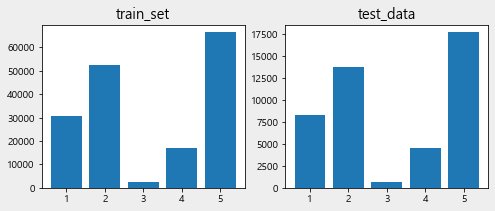

In [10]:

mpl.rc('figure', figsize=(8, 3))
fig = plt.figure( facecolor='#eeeeee')

plt.subplot(1,2,1)
plt.title('train_set', fontsize='x-large')
plt.bar(train_data.groupby(['SCORE']).count().index, train_data.groupby(['SCORE']).count()['REVIEW'].values)

plt.subplot(1,2,2)
plt.title('test_data',fontsize='x-large')
plt.bar(test_data.groupby(['SCORE']).count().index, test_data.groupby(['SCORE']).count()['REVIEW'].values)

plt.show()

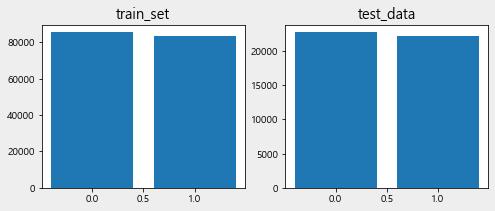

In [11]:

mpl.rc('figure', figsize=(8, 3))
fig = plt.figure( facecolor='#eeeeee')

plt.subplot(1,2,1)
plt.title('train_set', fontsize='x-large')
plt.bar(train_data.groupby(['label']).count().index, train_data.groupby(['label']).count()['REVIEW'].values)

plt.subplot(1,2,2)
plt.title('test_data',fontsize='x-large')
plt.bar(test_data.groupby(['label']).count().index, test_data.groupby(['label']).count()['REVIEW'].values)

plt.show()

### 3.데이터 정제/토큰화

In [12]:
# 정규 표현식 수행 : train
train_data.drop_duplicates(subset = ['REVIEW'], inplace=True) # 중복 제거
train_data['REVIEW'] = train_data['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

# Null 값 제거 : train
train_data['REVIEW'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거


# 정규 표현식 수행 : test
test_data.drop_duplicates(subset = ['REVIEW'], inplace=True) # 중복 제거
test_data['REVIEW'] = test_data['REVIEW'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행

# Null 값 제거 : test
test_data['REVIEW'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

In [13]:
%%time

okt = Okt()

# token화
# mecab = Mecab()
# print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와',
             '네', '들', '듯', '지', '임', '게', '요', '로', '하고', '으로', '안', '너무', '잘', ]

# token화 : train
train_data['tokenized'] = train_data['REVIEW'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# token화 : test
test_data['tokenized'] = test_data['REVIEW'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

Wall time: 38min 57s


### 4.단어와 길이 분포 확인하기

In [14]:
from collections import Counter

In [15]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [16]:
negative_word_count = Counter(negative_words)
positive_word_count = Counter(positive_words)

print(negative_word_count.most_common(10))
print(positive_word_count.most_common(10))

[('배송', 11454), ('그냥', 9483), ('맛', 7066), ('했는데', 6548), ('별로', 6102), ('제품', 5965), ('좀', 5769), ('못', 5714), ('생각', 5633), ('보다', 5595)]
[('좋아요', 16068), ('배송', 13773), ('재구매', 9126), ('구매', 7968), ('사용', 5734), ('가격', 5460), ('같아요', 4952), ('좋네요', 4530), ('제품', 4502), ('보다', 4441)]


In [17]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [33]:
df = pd.concat([train_data[['REVIEW', 'label']], test_data[['REVIEW', 'label']]]).reset_index(drop=True)

In [34]:
df.to_csv('./data.csv', index=False)

### 5.정수 인코딩 

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 101595
등장 빈도가 1번 이하인 희귀 단어의 수: 56372
단어 집합에서 희귀 단어의 비율: 55.48698262709779
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.798538675504645


In [19]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 45225


In [20]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 6.패딩 : 샘플들의 길이를 동일하게 맞춰주는 작업

리뷰의 최대 길이 : 254
리뷰의 평균 길이 : 11.93801449627518


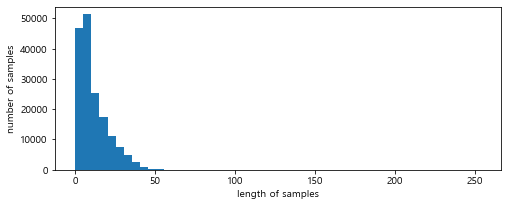

In [21]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [23]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.92236254911606


In [24]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 7.모델링 : GRU

In [25]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import pickle

embedding_dim = 100
hidden_units = 128
vocab_size = 45225

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         4522500   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 4,610,949
Trainable params: 4,610,949
Non-trainable params: 0
_________________________________________________________________


In [27]:
# training 
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2110/2110 [==============================] - 361s 169ms/step - loss: 0.3002 - acc: 0.8833 - val_loss: 0.2683 - val_acc: 0.8984

Epoch 00001: val_acc improved from -inf to 0.89839, saving model to best_model.h5
Epoch 2/15
2110/2110 [==============================] - 334s 159ms/step - loss: 0.2458 - acc: 0.9091 - val_loss: 0.2537 - val_acc: 0.9041

Epoch 00002: val_acc improved from 0.89839 to 0.90411, saving model to best_model.h5
Epoch 3/15
2110/2110 [==============================] - 334s 159ms/step - loss: 0.2254 - acc: 0.9185 - val_loss: 0.2473 - val_acc: 0.9065

Epoch 00003: val_acc improved from 0.90411 to 0.90651, saving model to best_model.h5
Epoch 4/15
2110/2110 [==============================] - 394s 187ms/step - loss: 0.2099 - acc: 0.9253 - val_loss: 0.2532 - val_acc: 0.9059

Epoch 00004: val_acc did not improve from 0.90651
Epoch 5/15
2110/2110 [==============================] - 403s 191ms/step - loss: 0.1976 - acc: 0.9301 - val_loss: 0.2617 - val_acc: 0.9047

Epo

In [28]:
# save

# model
model.save("GRU_model_200708.h5")

# tokenzier
with open('GRU_model_200708_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras.models import load_model
from tensorflow import keras
import pickle
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
# load

# model
loaded_model = keras.models.load_model('GRU_model_200708.h5')

# tokenzier
with open('GRU_model_200708_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [19]:

def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(loaded_model.predict(pad_new))
    print(score)
#     if(score < 0.4):
#         print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
#     else:
#         print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [20]:
okt = Okt()

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와',
             '네', '들', '듯', '지', '임', '게', '요', '로', '하고', '으로', '안', '너무', '잘', ]

In [22]:
sentiment_predict('진짜 고소하고 맛있어용')

0.9318230748176575


In [23]:
sentiment_predict('너무 달아요. 단맛을 줄여주세요')

0.1976781189441681


In [24]:
sentiment_predict('저는 재구매..안합니다. 사실 매일이기에 기대했어요. 그런데 탄산도 그렇고 달기도 그렇고 밍밍해요~ 오히려 연예인이 선전하는 물에 타먹는게 더 맛있네요')

0.036034464836120605


In [25]:
text = '6팩인줄 알았는데 6개일줄이야...달랑 커피 6개에 컵??!!? 이건 닫히지도 않고 누가 쓰던컵? 같은? 암튼 반품하기 귀찮아서 그냥둡니다.'
sentiment_predict(text)

0.0012753307819366455


In [26]:
text = '이게 6팩이 6페트를 의미하는거였나요?ㅠ 라이브 알림 보고 정확히 확인 안한 탓이라고 할수도 있지만 보통 6팩이라고 하면 포장된 6개의 팩을 의미하지 않나요? 6개가 포장된 6팩 즉 36개 커피라고 생각했는데 커피 6개라니 상품 정보에 오해소지가 너무 크내요 이걸 이유로 환불하기엔 환불 배송료가 너무 커서 그냥 먹긴해야겠내요.  또 리유저블 컵은 커피 껍질 재활용이라지만 딱봐도 누가 쓰던 컵인것 같아서 별로라고 생각됩니다.  저보다 먼저 리뷰 쓰신분들 진짜 허스키 컵 마음에 들어서 긍정적인 리뷰 쓴거 맞나요? 저랑 다른 퀄리티의 허스키 컵인가요?'
sentiment_predict(text)

0.0027833282947540283


In [46]:
import pandas as pd
df_1 = pd.read_excel('20220712_review_data2.xlsx',0)

review_list = list(df_1.REVIEW.str.replace('\n', ' '))

In [47]:
len(review_list)

588

In [60]:
def sentiment_predict2(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(loaded_model.predict(pad_new))
    if score <= 0.2:
        result = '부정'
    else:
        result = '중립/긍정'
    return result, round( (1-score)*100,2)

In [66]:
review_predict = []
review_ratio   = []

for text_ in review_list:
    try:
        (data_, ratio)  = sentiment_predict2(text_)
    except:
        (data_, ratio) = ('', '')
    review_predict.append(data_)
    review_ratio.append(ratio)

In [67]:
df_1['PREDICT'] = review_predict
df_1['NEGATIVE_RATIO'] = review_ratio

In [69]:
df_1[(df_1['PREDICT'] =='부정') ]

,USER,REG_DTM,REG_DT,REG_WEEK,CHANNEL,PRODUCT,SCORE,REVIEW,PREDICT,NEGATIVE_RATIO
0,okmi*****,2022-06-30,2022-06,2022Y-26W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",5,할인기간에 잘 구입했어요.\n맛은 그냥 먹을만하고 양은 300ml로 좀 작아요,부정,81.47
3,rlat********,2022-06-30,2022-06,2022Y-26W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",5,유통기한은 올해 11월 12월이에요\n베리리치맛마셔봣는데\n콤부차 특유의 톡쏨이 덜...,부정,93.94
57,keun*********,2022-06-30,2022-06,2022Y-26W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",5,맛은 그냥 데미소다 느낌이에요. 1+1이라 해서 샀는데 12개에 이가격이면 그냥 쏘...,부정,89.79
73,minj*****,2022-06-30,2022-06,2022Y-26W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",3,"1박스에 6개씩 다른맛으로 2박스시켰는데, 한박스에 오리지널 12개, 베리리치 12...",부정,97.86
114,yo****,2022-06-29,2022-06,2022Y-26W,3 네이버,더그레잇티 콤부차 [ 오리지널 ] [ 300ML ],5,"탄산감은 너무 좋고, 맛은 얼***보단 덜 새콤한것같아서 살짝 아쉽긴했지만 반대로 ...",부정,99.28
124,cold*****,2022-06-28,2022-06,2022Y-26W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",3,그럭저럭 괜찮은 정도,부정,92.63
141,pigg***,2022-06-27,2022-06,2022Y-26W,3 네이버,더그레잇티 콤부차 [ 오리지널 ] [ 300ML ],4,에구6천원이나 더 주고 사서 아깝네요. ㅠ\n라이브방송에서 싸게 사서 좋아서 더 살...,부정,99.15
169,boan*****,2022-06-25,2022-06,2022Y-25W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",5,박스가 찌그러져있고 쪼금만 망가졌으면 열릴것같은 상태였지만 다행히 그렇진 않았어요....,부정,87.10
205,leom****,2022-06-24,2022-06,2022Y-25W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",5,생각보다 많이 시큼해요. 특히 오리지널이 그래요. 여성분들은 좋아할 것 같아요. 발...,부정,96.78
218,jeso******,2022-06-23,2022-06,2022Y-25W,3 네이버,"더그레잇티 콤부차 [ 베리리치 ] [ 300ML ] ,더그레잇티 콤부차 [ 오리지널...",4,달아요 당을 줄였음 좋겠네요\n탄산은 약한편인데 나쁘지않아요,부정,85.98
